In [2]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import cmocean
import h5py
CMAP = cmocean.cm.balance
CMAP = seaborn.cm.icefire

In [3]:
def energy_specturm(u,v):
    # Script for the computation of 3D spectrum of the Total Kinetic Energy
    # Adapted to the Taylor-Green vortex (TGV) problem.
    # CREATED by FARSHAD NAVAH
    # McGill University
    # farshad.navah .a.t. mail.mcgill.ca
    # 2018
    # provided as is with no garantee.
    # Please cite:
    #    https://github.com/fanav/Energy_Spectrum
    #    https://arxiv.org/abs/1809.03966

    # -----------------------------------------------------------------
    #  IMPORTS - ENVIRONMENT
    # -----------------------------------------------------------------

    import numpy as np
    import matplotlib.pyplot as plt
    import time
    from math import sqrt

    # -----------------------------------------------------------------
    #  TGV QUANTS
    # -----------------------------------------------------------------

    # These quantities are to account for particular non-dimensionalizations of state variables.
    # In general U0=1.
    c  = sqrt(1.4);
    Ma = 0.1;
    U0 = 1.0; 

    #load the ascii file
    data = np.stack((u,v),axis=1)

    print ("shape of data = ",data.shape)

    localtime = time.asctime( time.localtime(time.time()) )
    print ("Reading files...localtime",localtime, "- END\n")

    # -----------------------------------------------------------------
    #  COMPUTATIONS
    # -----------------------------------------------------------------
    localtime = time.asctime( time.localtime(time.time()) )
    print ("Computing spectrum... ",localtime)

    N = data.shape[-1]
    M= data.shape[-2]
    print("N =",N)
    print("M =",M)
    eps = 1e-16 # to void log(0)

    U = data[:,0].mean(axis=0)
    V = data[:,1].mean(axis=0)
    # U = data[:,3].reshape(N,N,N)/U0
    # V = data[:,4].reshape(N,N,N)/U0
    # W = data[:,5].reshape(N,N,N)/U0

    amplsU = abs(np.fft.fftn(U)/U.size)
    amplsV = abs(np.fft.fftn(V)/V.size)
    print(f"amplsU.shape = {amplsU.shape}")
    # amplsW = abs(np.fft.fftn(W)/W.size)

    EK_U  = amplsU**2
    EK_V  = amplsV**2 
    # EK_W  = amplsW**2 

    EK_U = np.fft.fftshift(EK_U)
    EK_V = np.fft.fftshift(EK_V)
    # EK_W = np.fft.fftshift(EK_W)

    sign_sizex = np.shape(EK_U)[0]
    sign_sizey = np.shape(EK_U)[1]
    # sign_sizez = np.shape(EK_U)[2]

    box_sidex = sign_sizex
    box_sidey = sign_sizey
    # box_sidez = sign_sizez

    # box_radius = int(np.ceil((np.sqrt((box_sidex)**2+(box_sidey)**2+(box_sidez)**2))/2.)+1)
    box_radius = int(np.ceil((np.sqrt((box_sidex)**2+(box_sidey)**2))/2.)+1)
    centerx = int(box_sidex/2)
    centery = int(box_sidey/2)
    # centerz = int(box_sidez/2)

    print ("box sidex     =",box_sidex) 
    print ("box sidey     =",box_sidey) 
    # print ("box sidez     =",box_sidez)
    print ("sphere radius =",box_radius )
    print ("centerbox     =",centerx)
    print ("centerboy     =",centery)
    # print ("centerboz     =",centerz,"\n" )
                    
    EK_U_avsphr = np.zeros(box_radius,)+eps ## size of the radius
    EK_V_avsphr = np.zeros(box_radius,)+eps ## size of the radius
    # EK_W_avsphr = np.zeros(box_radius,)+eps ## size of the radius

    # for i in range(box_sidex):
    # 	for j in range(box_sidey):
    # 		for k in range(box_sidez):            
    # 			wn =  int(np.round(np.sqrt((i-centerx)**2+(j-centery)**2+(k-centerz)**2)))
    # 			EK_U_avsphr[wn] = EK_U_avsphr [wn] + EK_U [i,j,k]
    # 			EK_V_avsphr[wn] = EK_V_avsphr [wn] + EK_V [i,j,k]    
    # 			EK_W_avsphr[wn] = EK_W_avsphr [wn] + EK_W [i,j,k]        
    for i in range(box_sidex):
        for j in range(box_sidey):          
            wn =  int(np.round(np.sqrt((i-centerx)**2+(j-centery)**2)))
            EK_U_avsphr[wn] = EK_U_avsphr [wn] + EK_U [i,j]
            EK_V_avsphr[wn] = EK_V_avsphr [wn] + EK_V [i,j]     
    EK_avsphr = 0.5*(EK_U_avsphr + EK_V_avsphr)
                            

    realsize = len(np.fft.rfft(U[:,0]))

    TKEofmean_discrete = 0.5*(np.sum(U/U.size)**2+np.sum(V/V.size)**2)
    TKEofmean_sphere   = EK_avsphr[0]

    total_TKE_discrete = np.sum(0.5*(U**2+V**2))/(N*M) # average over whole domaon / divied by total pixel-value
    total_TKE_sphere   = np.sum(EK_avsphr)

    result_dict = {
    "Real Kmax": realsize,
    "Spherical Kmax": len(EK_avsphr),
    "KE of the mean velocity discrete": TKEofmean_discrete,
    "KE of the mean velocity sphere": TKEofmean_sphere,
    "Mean KE discrete": total_TKE_discrete,
    "Mean KE sphere": total_TKE_sphere
    }
    print(result_dict)
    localtime = time.asctime( time.localtime(time.time()) )
    print ("Computing spectrum... ",localtime, "- END \n")
    return realsize, EK_avsphr,result_dict
    # fig = plt.figure()
    # plt.title("Kinetic Energy Spectrum")
    # plt.xlabel(r"k (wavenumber)")
    # plt.ylabel(r"TKE of the k$^{th}$ wavenumber")

    # print(realsize)
    # plt.loglog(np.arange(0,realsize),((EK_avsphr[0:realsize] )),'k')
    # plt.loglog(np.arange(realsize,len(EK_avsphr),1),((EK_avsphr[realsize:] )),'k--')
    # axes = plt.gca()





In [4]:
import h5py
def get_data_scale(data_name):
    data_info = {"decay_turb":['../Decay_Turbulence_small/train/Decay_turb_small_128x128_7202.h5', 0.02],
                 "burger2d": ["../Burgers_2D_small/train/Burgers2D_128x128_702.h5",0.001],
                 "rbc": ["../RBC_small/train/RBC_small_165_s2.h5",0.01]}
    f = h5py.File(data_info[data_name][0],'r')
    w = f['tasks']['vorticity'][()] if data_name != "burger2d" else None
    u = f['tasks']['u'][()]
    v = f['tasks']['v'][()]
    print(f"************{data_name}************")
    print(f"max w: {np.max(w):.2f}, min w: {np.min(w):.2f}") if data_name != "burger2d" else None
    print(f"mean w: {np.mean(w):4f}, std w: {np.std(w):.4f}") if data_name != "burger2d" else None
    print(f"max u: {np.max(u):.4f}, min u: {np.min(u):.4f}")
    print(f"mean u: {np.mean(u):.4f}, std u: {np.std(u):.4f}")
    print(f"max v: {np.max(v):.4f}, min v: {np.min(v):.4f}")
    print(f"mean v: {np.mean(v):.4f}, std v: {np.std(v):.4f}")
    f.close()
    return None

get_data_scale("decay_turb")
get_data_scale("burger2d")
get_data_scale("rbc")

************decay_turb************
max w: 7.82, min w: -5.72
mean w: -0.000029, std w: 1.1907
max u: 1.5468, min u: -1.4452
mean u: -0.0000, std u: 0.4451
max v: 1.9174, min v: -1.4077
mean v: 0.0000, std v: 0.4559
************burger2d************
max u: 2.7903, min u: -1.2097
mean u: 0.8246, std u: 0.2483
max v: 1.6623, min v: -2.1578
mean v: -0.3140, std v: 0.3626
************rbc************
max w: 33.45, min w: -33.47
mean w: -0.033876, std w: 4.5677
max u: 0.6425, min u: -0.5935
mean u: -0.0007, std u: 0.1942
max v: 0.7396, min v: -0.6896
mean v: 0.0000, std v: 0.1997


# Data Visualization

In [5]:

import h5py
def plot_data(data_name = "burger2d",row=10,col=10,timescale_factor =10 ,in_channel=2,vmin=-1,vmax=1):

    data_info = {"decay_turb":['../Decay_Turbulence_small/train/Decay_turb_small_128x128_7202.h5', 0.02],
                 "burger2d": ["../Burgers_2D_small/train/Burgers2D_128x128_702.h5",0.001],
                 "rbc": ["../RBC_small/train/RBC_small_165_s2.h5",0.01]}
    f = h5py.File(data_info[data_name][0],'r')
    if data_name == "rbc":
        print(f['scales/sim_time'][()])
        t = int(f['scales/sim_time'][0])
    else:
        print(f['tasks']['t'][()])
        t = np.ceil(f['tasks']['t'][0])
    print(f['tasks']['u'].shape)
    if data_name == "burger2d" and in_channel ==1:
        raise ValueError("Burger2D doesnt have vorticity channel")
    else:
        if in_channel == 1:
            w = f['tasks']['vorticity'][()]
            fig,axs = plt.subplots(row,col,figsize=(20,20))
            i = 0
            for ax in axs:
                for a in ax:
                    a.axis('off')
                    a.imshow(w[i*timescale_factor],cmap=CMAP,vmin=vmin,vmax=vmax)
                    a.set_title(f"t={t + i*timescale_factor*data_info[data_name][1]:.4}")
                    i+=1
        elif in_channel == 2:
            u = f['tasks']['u'][()]
            v = f['tasks']['v'][()]
            fig,axs = plt.subplots(row,col,figsize=(20,20))
            i = 0
            for ax in axs:
                for a in ax:
                    a.axis('off')
                    a.imshow(u[i*timescale_factor],cmap=CMAP,vmin=vmin[0],vmax=vmax[0])
                    a.set_title(f"t={t + i*timescale_factor*data_info[data_name][1]:.4}")
                    i+=1

            fig,axs = plt.subplots(row,col,figsize=(20,20))
            i = 0
            for ax in axs:
                for a in ax:
                    a.axis('off')
                    a.imshow(v[i*timescale_factor],cmap=CMAP,vmin=vmin[1],vmax=vmax[1])
                    a.set_title(f"t={t + i*timescale_factor*data_info[data_name][1]:.4}")
                    i+=1
        elif in_channel == 3:
            u = f['tasks']['u'][()]
            v = f['tasks']['v'][()]
            w = f['tasks']['vorticity'][()]
            fig,axs = plt.subplots(row,col,figsize=(20,20))
            i = 0
            for ax in axs:
                for a in ax:
                    a.axis('off')
                    a.imshow(u[i*timescale_factor],cmap=CMAP,vmin=vmin[0],vmax=vmax[0])
                    a.set_title(f"t={t + i*timescale_factor*data_info[data_name][1]:.4}")
                    i+=1

            fig,axs = plt.subplots(row,col,figsize=(20,20))
            i = 0
            for ax in axs:
                for a in ax:
                    a.axis('off')
                    a.imshow(v[i*timescale_factor],cmap=CMAP,vmin=vmin[1],vmax=vmax[1])
                    a.set_title(f"t={t + i*timescale_factor*data_info[data_name][1]:.4}")
                    i+=1
            fig,axs = plt.subplots(row,col,figsize=(20,20))
            i = 0
            for ax in axs:
                for a in ax:
                    a.axis('off')
                    a.imshow(w[i*timescale_factor],cmap=CMAP,vmin=vmin[2],vmax=vmax[2])
                    a.set_title(f"t={t + i*timescale_factor*data_info[data_name][1]:.4}")
                    i+=1
    f.close()
    return print("visualization done")


## RBC

************rbc************
max w: 33.45, min w: -33.47
mean w: -0.033876, std w: 4.5677
max u: 0.6425, min u: -0.5935
mean u: -0.0007, std u: 0.1942
max v: 0.7396, min v: -0.6896
mean v: 0.0000, std v: 0.1997
[20.00040028 20.01040028 20.02040028 ... 39.97449828 39.98443195
 39.99436562]
(2000, 256, 64)
visualization done


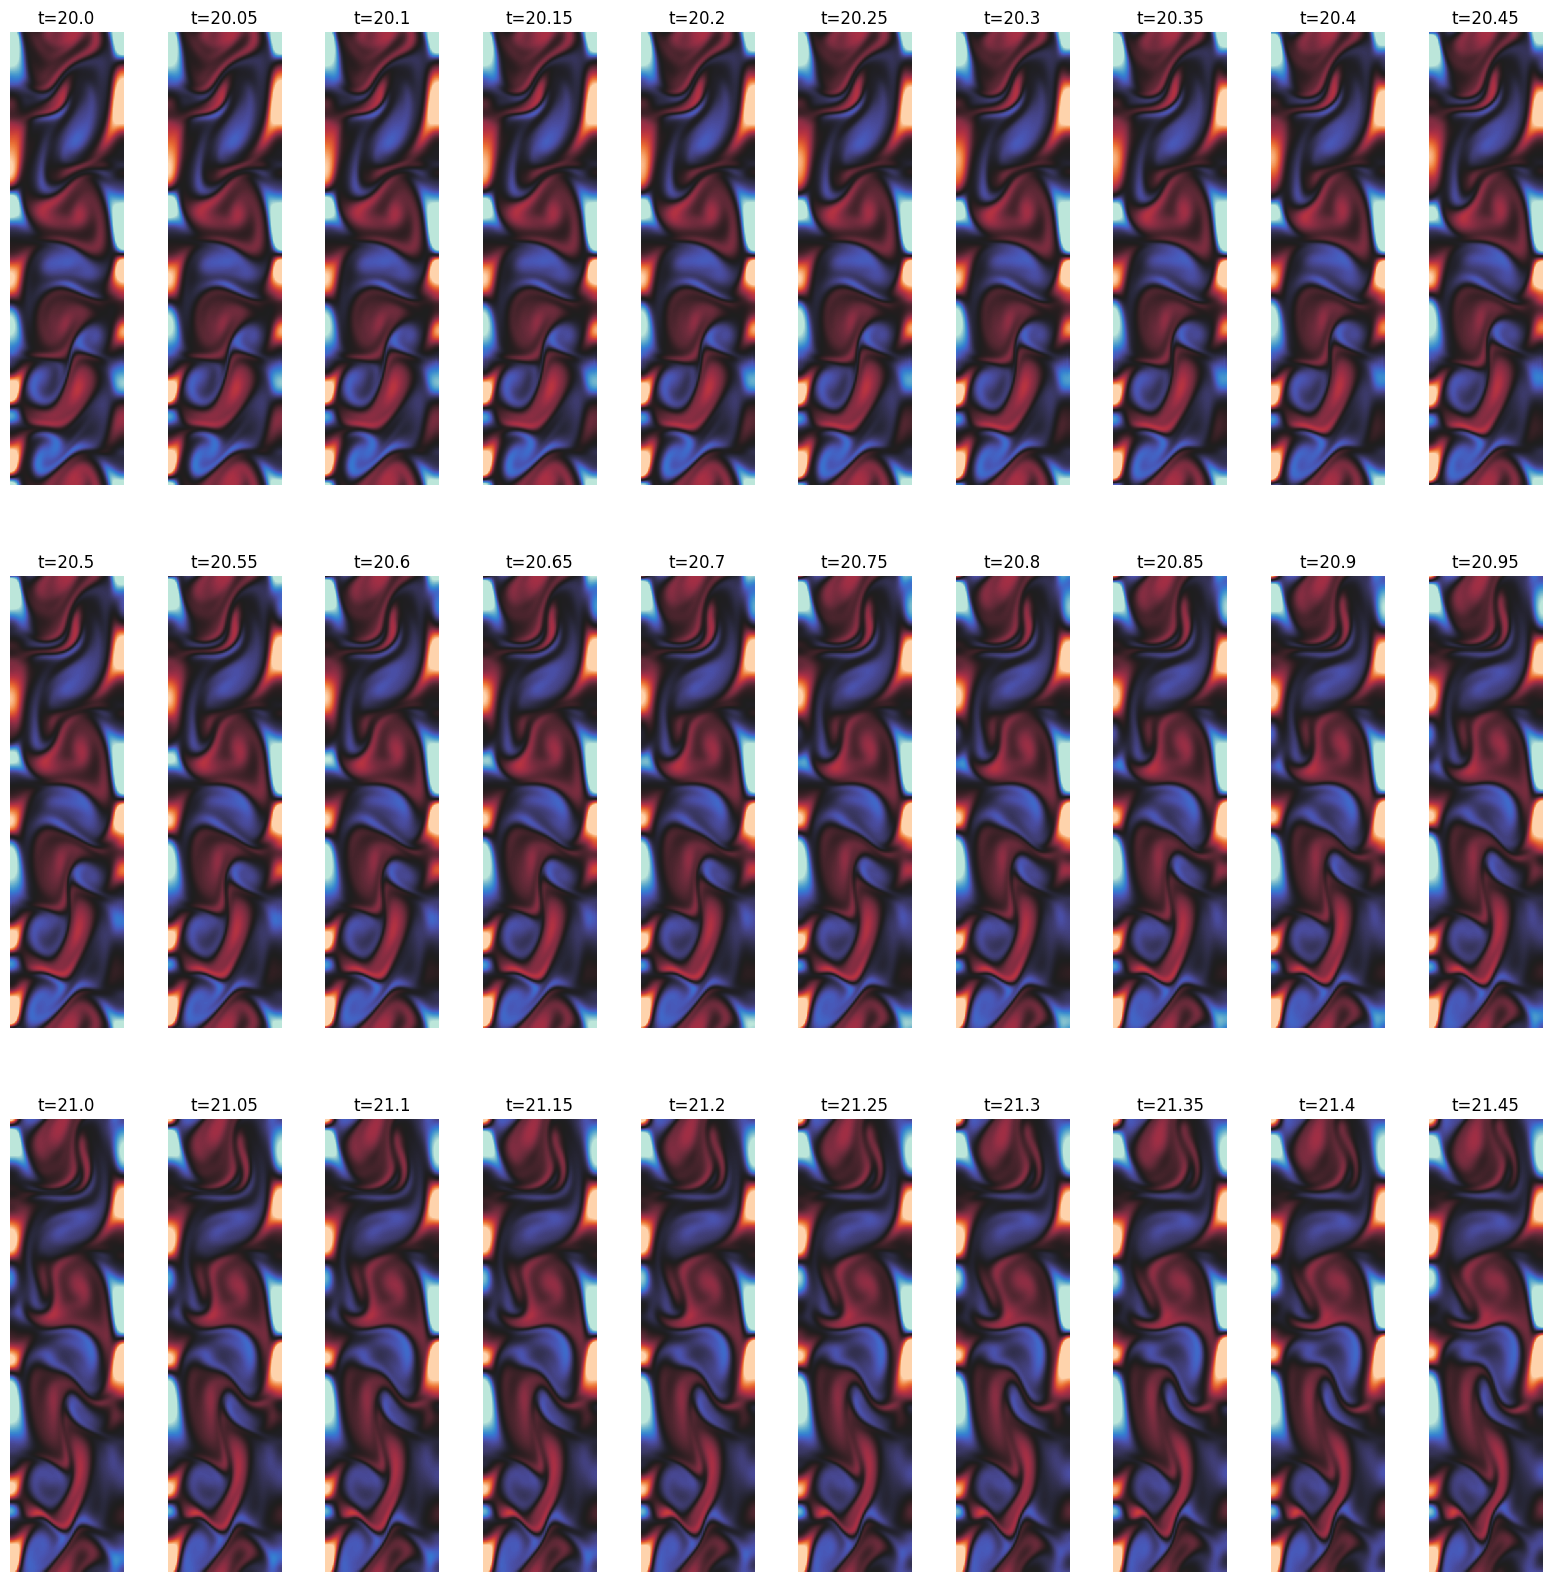

In [6]:
get_data_scale("rbc")
plot_data(data_name = "rbc",timescale_factor =5 ,in_channel=1,vmin=-10,vmax=10,row=3,col=10)

# Burgers

************burger2d************
max u: 2.7903, min u: -1.2097
mean u: 0.8246, std u: 0.2483
max v: 1.6623, min v: -2.1578
mean v: -0.3140, std v: 0.3626
[0.00000000e+00 9.99000999e-04 1.99800200e-03 ... 9.98001998e-01
 9.99000999e-01 1.00000000e+00]
(1001, 128, 128)
visualization done


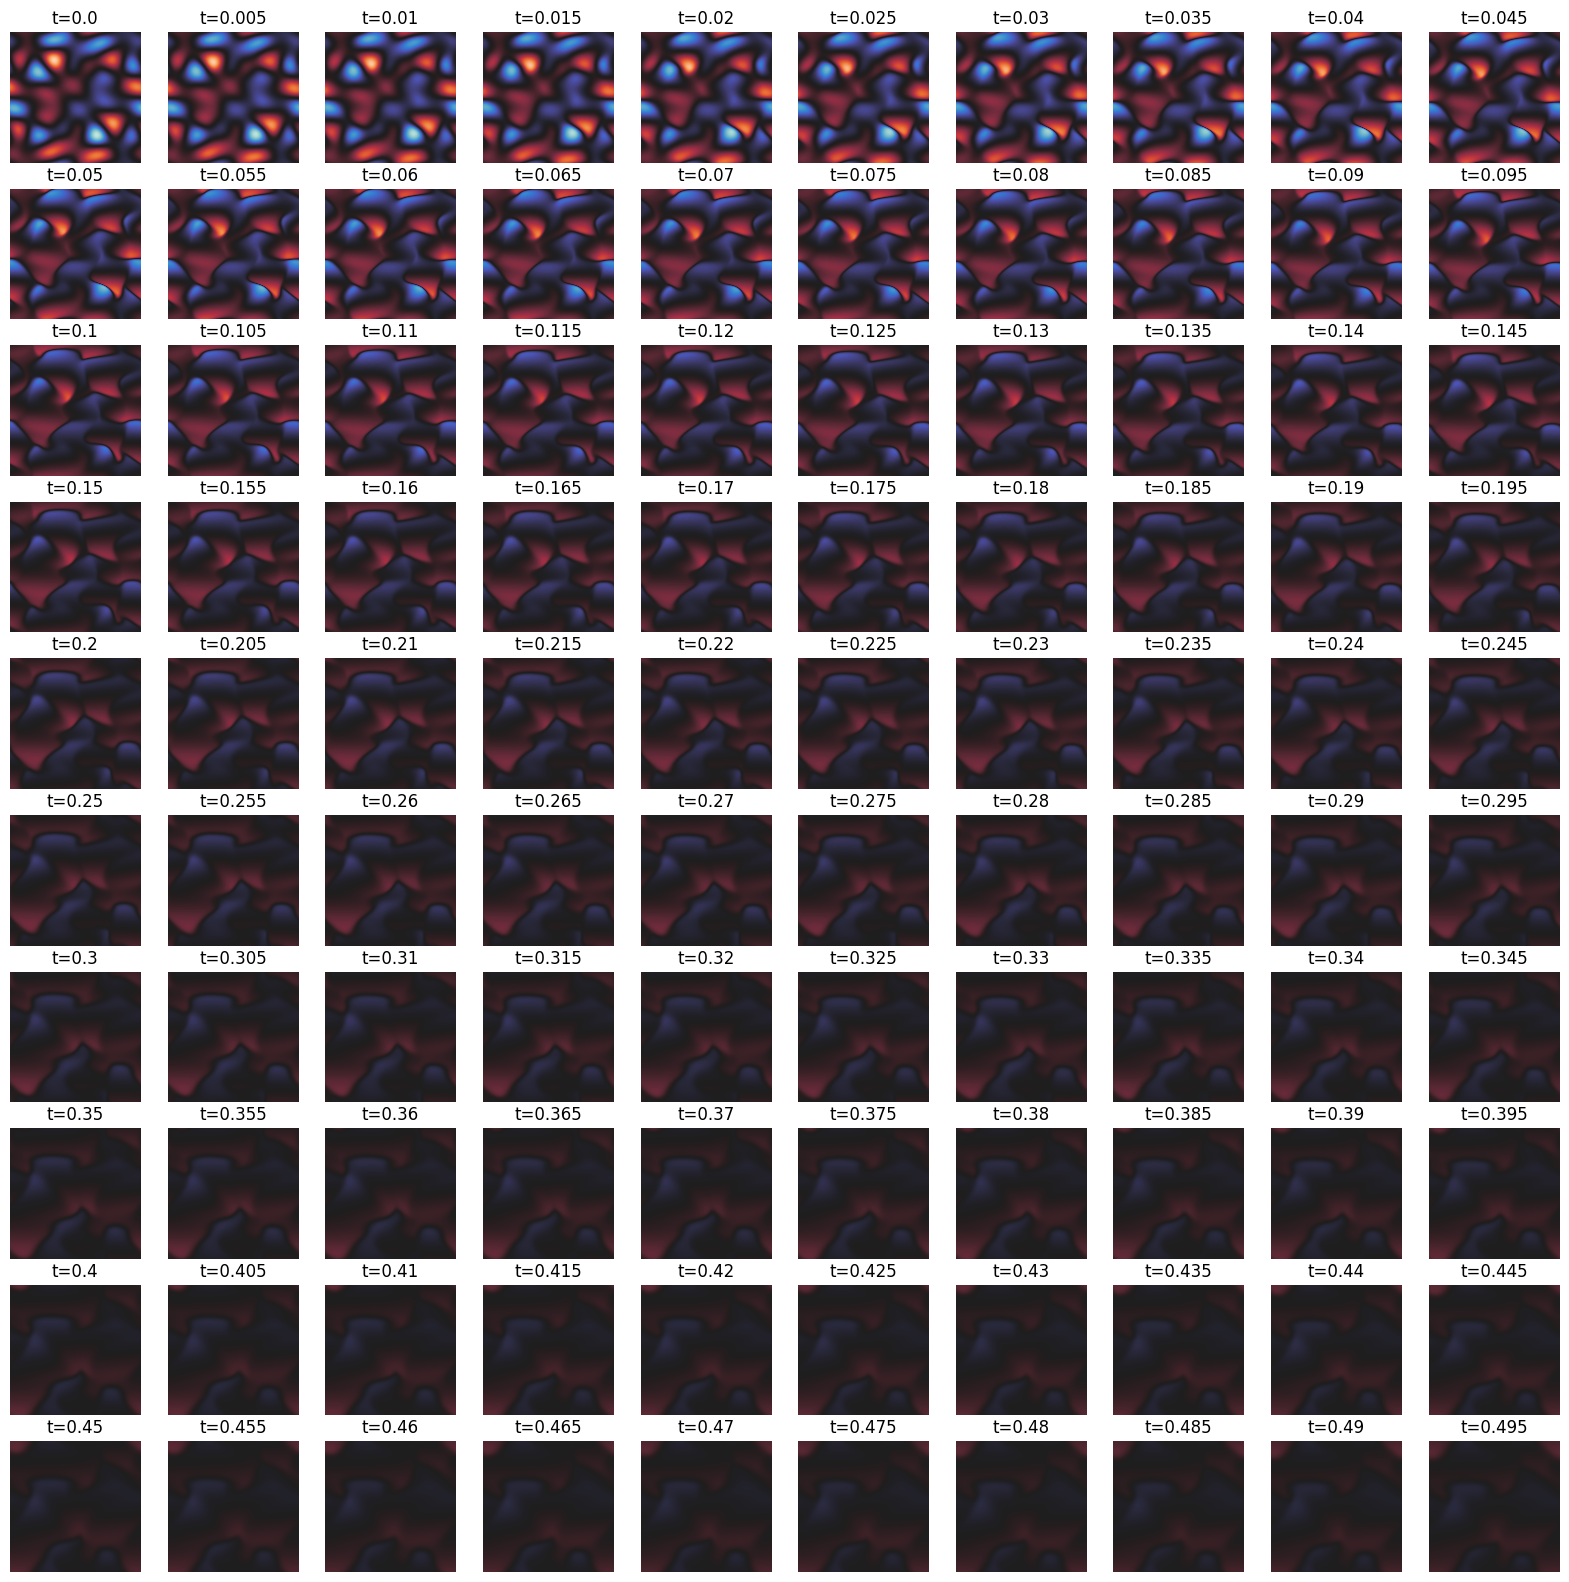

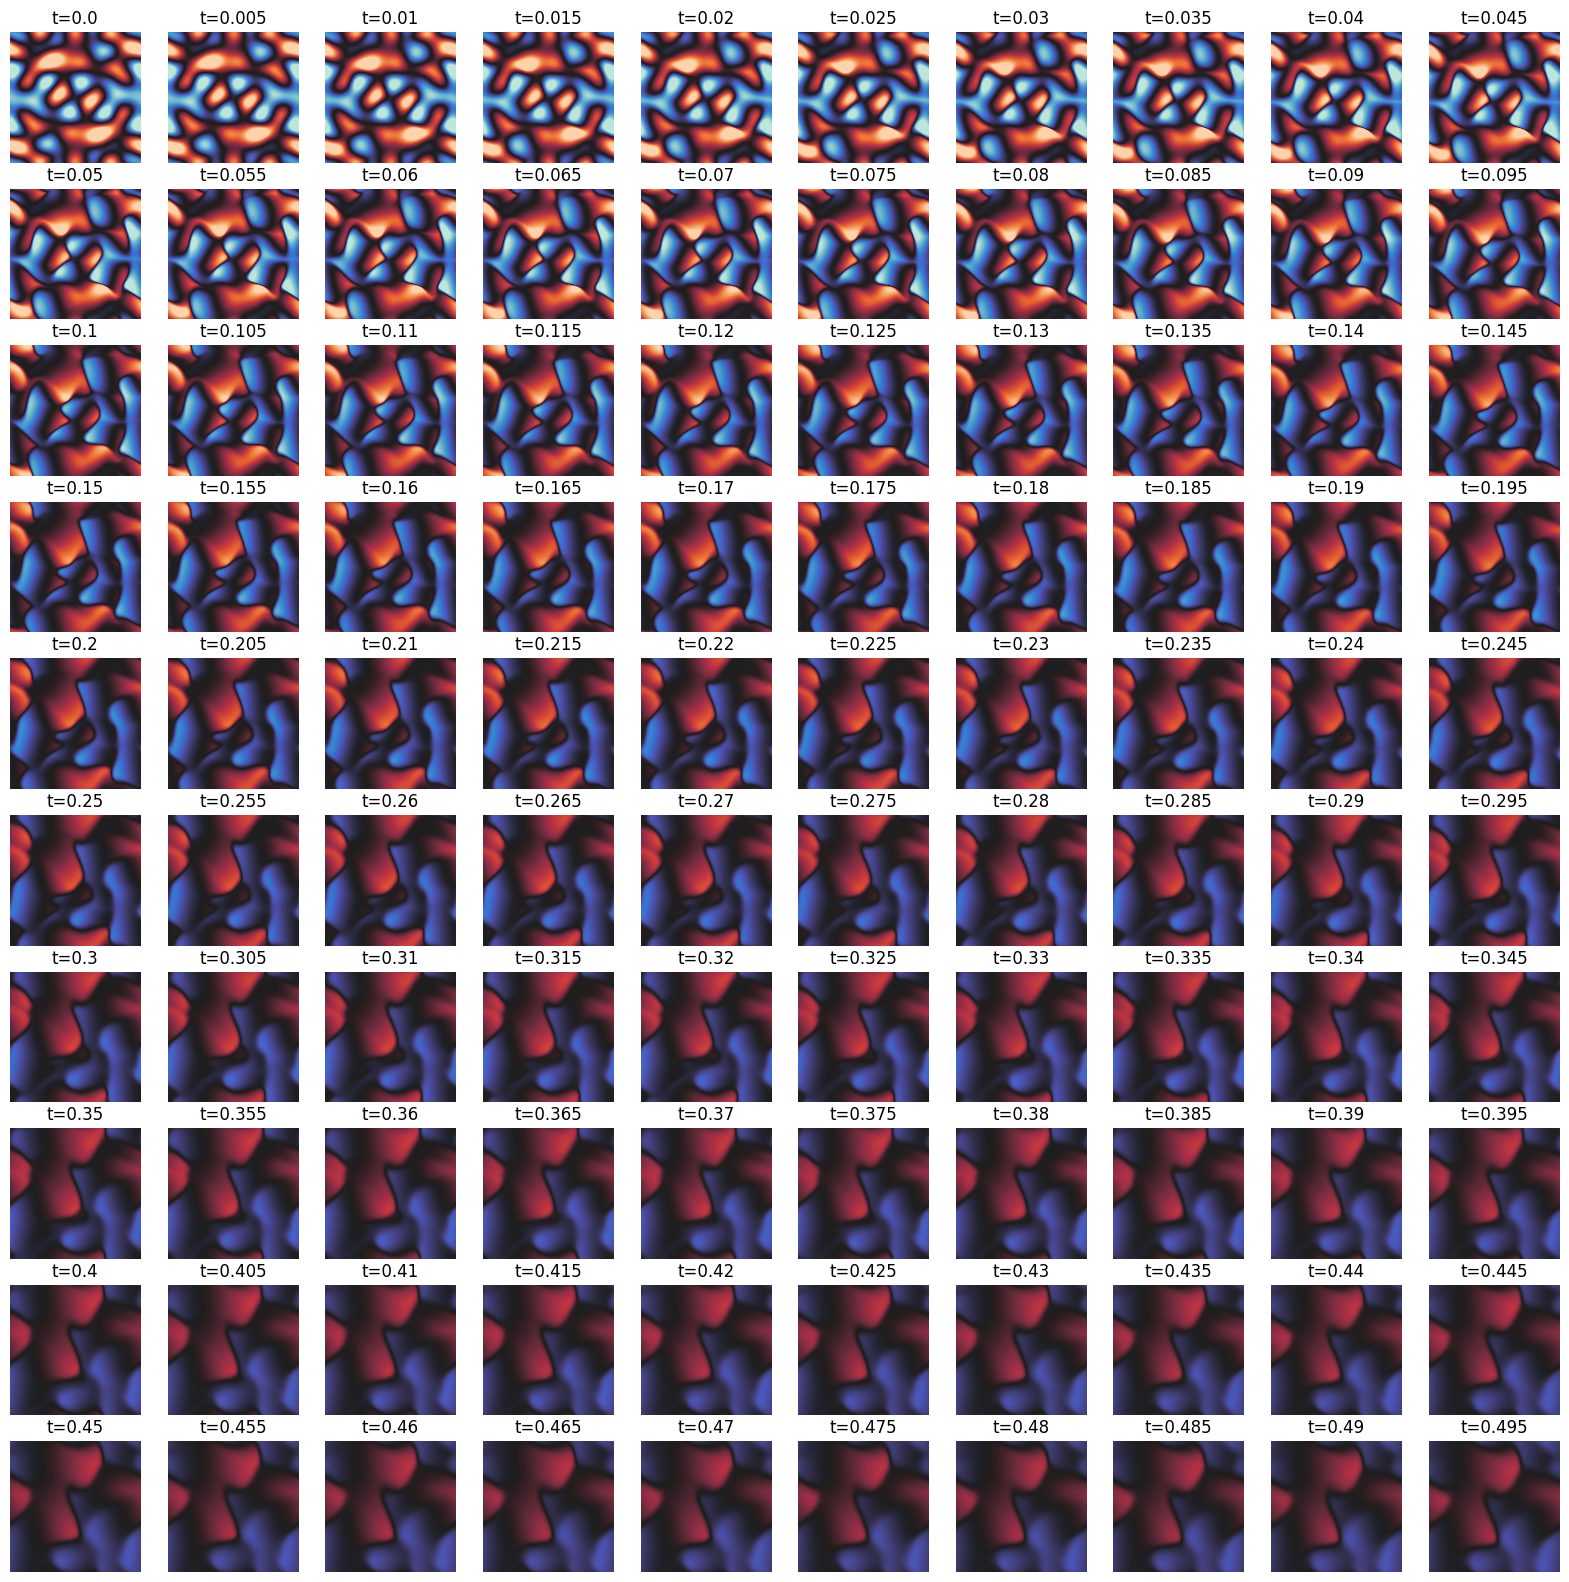

In [7]:
get_data_scale("burger2d")
plot_data(data_name = "burger2d",timescale_factor =5 ,in_channel=2,vmin=[-1.2,-1.6],vmax=[2.8,1],row=10,col=10)

# Decay Turb

************decay_turb************
max w: 7.82, min w: -5.72
mean w: -0.000029, std w: 1.1907
max u: 1.5468, min u: -1.4452
mean u: -0.0000, std u: 0.4451
max v: 1.9174, min v: -1.4077
mean v: 0.0000, std v: 0.4559
[ 4.90873852  4.92101037  4.93328221 ... 29.41561559 29.42788743
 29.44015928]
(2000, 128, 128)
visualization done


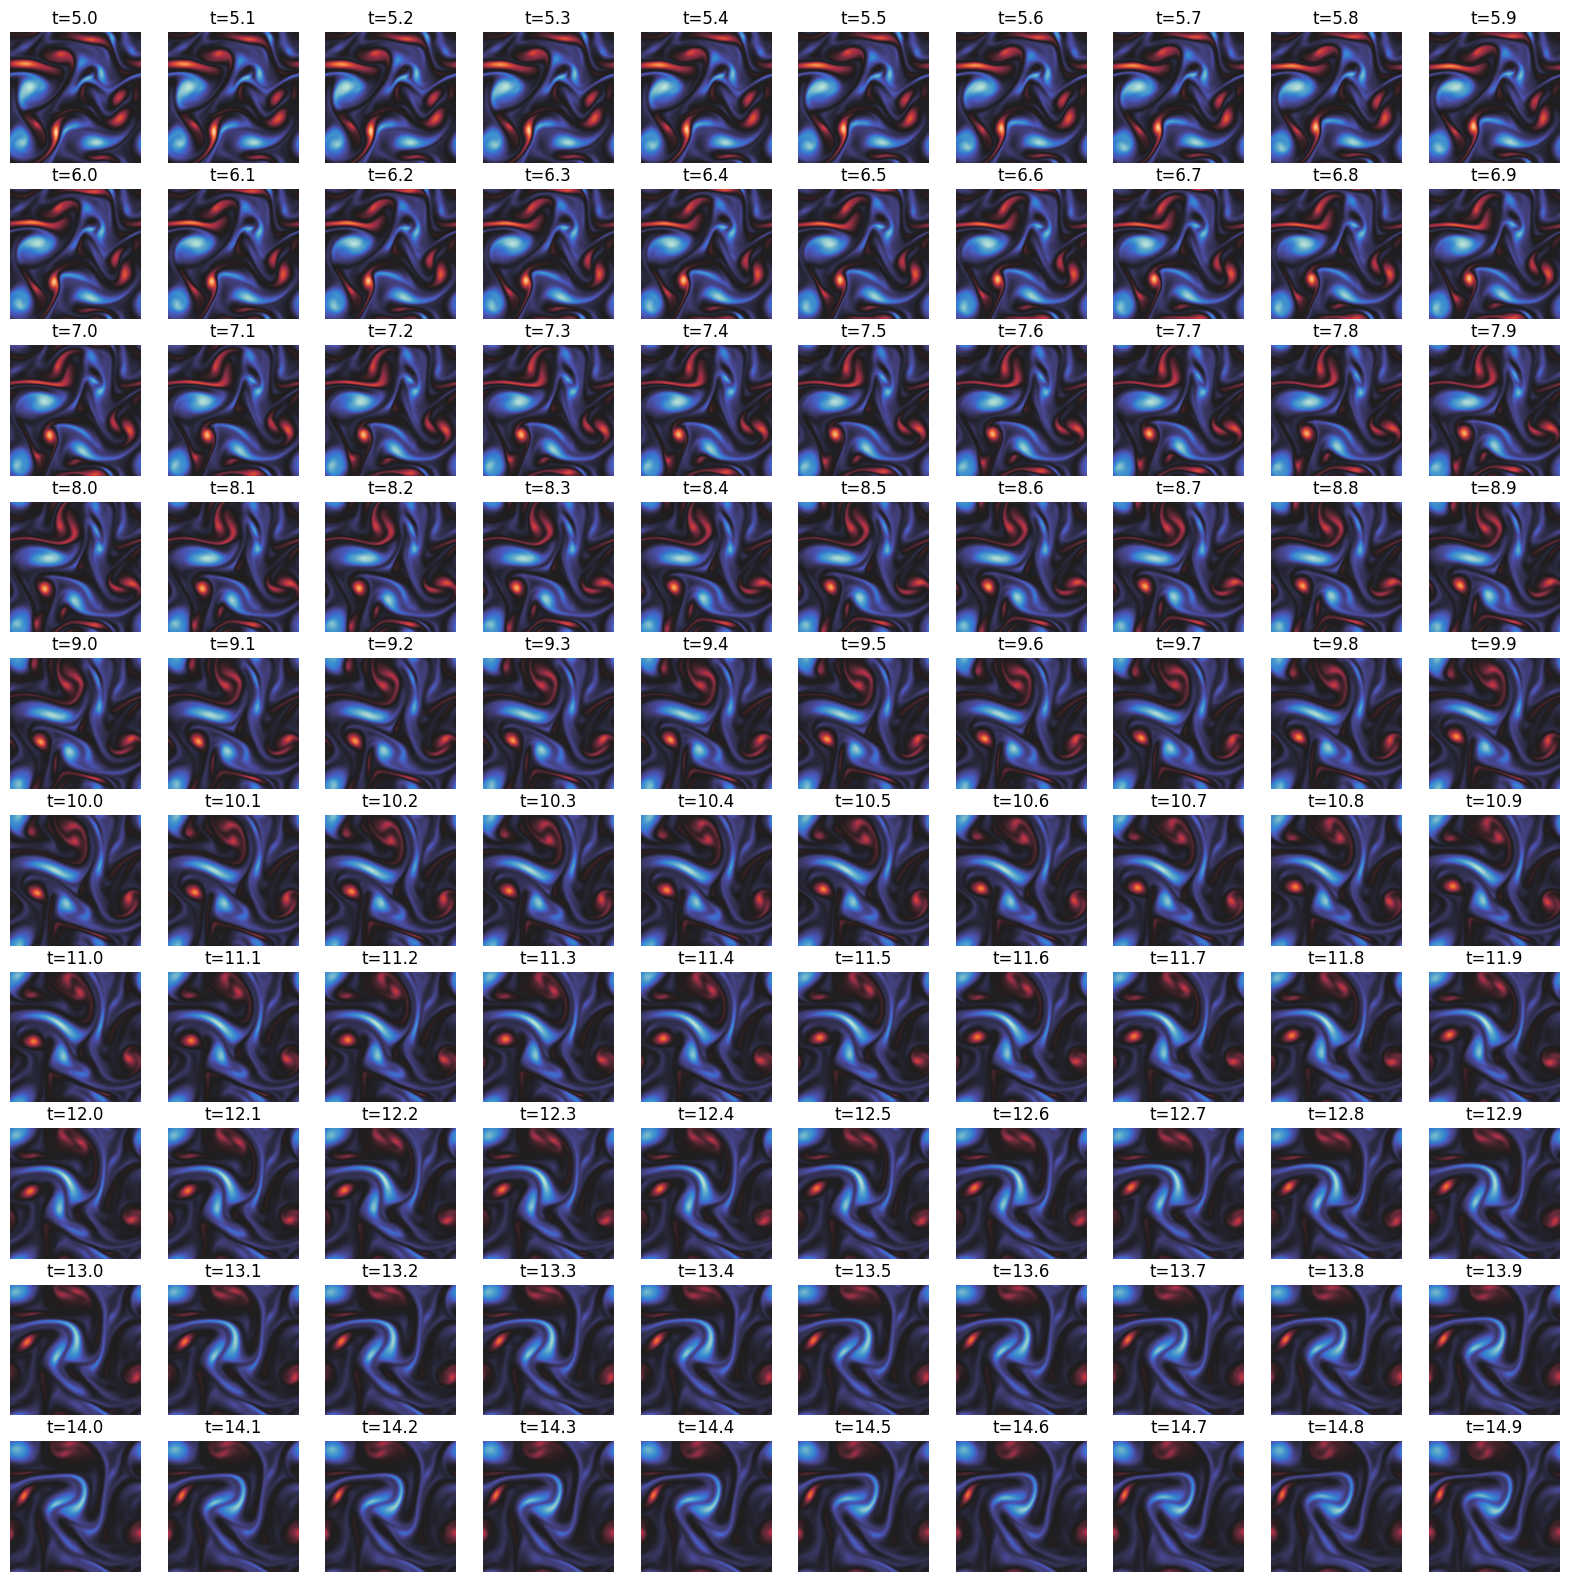

In [8]:
get_data_scale("decay_turb")
plot_data(data_name = "decay_turb",timescale_factor =5 ,in_channel=1,vmin=-5.7,vmax=7.82,row=10,col=10)

In [9]:
def generate_test_matrix(cols:int, final_index:int):
    # Calculate the number of rows based on the final index and number of columns
    rows = (final_index + 1) // (cols - 1)
    
    # Check if an additional row is needed to reach the final index
    if (final_index + 1) % (cols - 1) != 0:
        rows += 1
    
    # Initialize a matrix filled with zeros
    matrix = np.zeros((rows, cols),dtype=int)
    
    # Fill the matrix according to the specified pattern
    current_value = 0
    for i in range(rows):
        for j in range(cols):
            if current_value <= final_index:
                matrix[i, j] = current_value
                current_value += 1
        current_value -= 1  # Repeat the last element in the next row
                
    return matrix[:-1,:]

import torch
import torchvision.transforms as transforms
from PIL import Image, ImageFilter
def get_test_data(data_name,timescale_factor = 10,num_snapshot = 10,in_channel=1,upscale_factor=4):
    data_info = {"decay_turb":['../Decay_Turbulence_small/test/Decay_turb_small_128x128_79.h5', 0.02],
                 "burger2d": ["../Burgers_2D_small/test/Burgers2D_128x128_79.h5",0.001],
                 "rbc": ["../RBC_small/test/RBC_small_33_s2.h5",0.01]}
    with h5py.File(data_info[data_name][0],'r') as f:
        w_truth = f['tasks']['vorticity'][()] if in_channel ==1 or in_channel ==3 else None
        u_truth = f['tasks']['u'][()]
        v_truth = f['tasks']['v'][()]
    final_index = (u_truth.shape[0]-1)//timescale_factor
    idx_matrix = generate_test_matrix(num_snapshot +1 , final_index)*timescale_factor    
    print(idx_matrix[1:4])
    if in_channel ==1:
        hr_input = w_truth[idx_matrix[:,0]]
        hr_target = w_truth[idx_matrix[:,:]]
    elif in_channel ==2:
        hr_input = np.stack((u_truth[idx_matrix[:,0]],v_truth[idx_matrix[:,0]]),axis=1)
        hr_target = np.stack((u_truth[idx_matrix[:,:]],v_truth[idx_matrix[:,:]]),axis=2)
    elif in_channel ==3:
        hr_input = np.stack((w_truth[idx_matrix[:,0]],u_truth[idx_matrix[:,0]],v_truth[idx_matrix[:,0]]),axis=1)
        hr_target = np.stack((w_truth[idx_matrix[:,:]],u_truth[idx_matrix[:,:]],v_truth[idx_matrix[:,:]]),axis=2)
    # to low resolution
    print(hr_target.shape)
    transform = torch.from_numpy
    img_shape_x = hr_input.shape[-2]
    img_shape_y = hr_input.shape[-1]
    input_transform = transforms.Resize((int(img_shape_x/upscale_factor),int(img_shape_y/upscale_factor)),Image.BICUBIC,antialias=False)
    
    # to tensor
    lr_input_tensor = input_transform(transform(hr_input))
    hr_target_tensor = transform(hr_target)
    lr_input_tensor = lr_input_tensor.unsqueeze(1) if in_channel ==1 else lr_input_tensor
    hr_target_tensor = hr_target_tensor.unsqueeze(2) if in_channel ==1 else hr_target_tensor
    lr_input = lr_input_tensor.numpy()
    # print(idx_matrix[:,0])
    return lr_input,hr_target,lr_input_tensor,hr_target_tensor

# lr_input,hr_target,lr_input_tensor,hr_target_tensor = get_test_data("rbc",timescale_factor = 5,num_snapshot = 20,in_channel=3,upscale_factor=4)



from src.models import *
def get_prediction(model_dic,lr_input_tensor,hr_target_tensor,scale_factor,in_channels,task_dt,n_snapshot,ode_step):
    model = PASR_MLP(upscale=scale_factor, in_chans=in_channels, img_size=256, window_size=8, depths=[6, 6, 6, 6], embed_dim=60, num_heads=[6, 6, 6, 6], mlp_ratio=2, upsampler="pixelshuffle", resi_conv='1conv',mean=[0],std=[1])
    model = torch.nn.DataParallel(model).cuda()
    checkpoint = torch.load(model_dic)
    model_dic = checkpoint['model_state_dict']
    model.load_state_dict(model_dic)
    model.eval()
    with torch.no_grad():
        pred0 = model(lr_input_tensor.float().cuda(),task_dt = task_dt,n_snapshot = n_snapshot,ode_step = ode_step,time_evol = False)
        pred = model(lr_input_tensor.float().cuda(),task_dt = task_dt,n_snapshot = n_snapshot,ode_step = ode_step,time_evol = True)
        pred = torch.cat((pred0,pred),dim=1)
    ## add RFNE RINE PSNR SSIM in the future 
    return pred.detach().cpu().numpy()

# model_dic = "results/PASR_MLP_small_data_rbc_small_crop_size_256_ode_step_8_ode_method_Euler_task_dt_4_num_snapshots_20_upscale_factor_4_timescale_factor_5_loss_type_L1_lamb_0.3_lr_0.0003_gamma_0.95_normalizaiton_Falsetensor([[736]]).pt"
# pred = get_prediction(model_dic,lr_input_tensor,hr_target_tensor,scale_factor=4,in_channels=3,task_dt=4,n_snapshot=20,ode_step=8)

# transform = torch.from_numpy
# upscale_factor = 4
# img_shape_x = 128
# img_shape_y = 128
# input_transform = transforms.Resize((int(img_shape_x/upscale_factor),int(img_shape_y/upscale_factor)),Image.BICUBIC,antialias=False)
# uv_tensor = transform(uv)
# w_lr = input_transform(uv_tensor)

# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# checkpoint = torch.load("results/PASR_MLP_small_data_Burger2D_small_crop_size_256_ode_step_8_ode_method_Euler_task_dt_4_num_snapshots_20_upscale_factor_4_timescale_factor_10_loss_type_L1_lamb_1.0_lr_0.000

/home/raocp/anaconda3/envs/torch2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Energy Specturm

In [10]:
import h5py
import torchaudio


def plot_energy_specturm(u_truth,v_truth,u_pred,v_pred,data_name):
    data_info = {"decay_turb":['../Decay_Turbulence_small/test/Decay_turb_small_128x128_79.h5', 0.02],
                 "burger2d": ["../Burgers_2D_small/test/Burgers2D_128x128_79.h5",0.001],
                 "rbc": ["../RBC_small/test/RBC_small_33_s2.h5",0.01]}
    realsize_truth, EK_avsphr_truth,result_dict_truth = energy_specturm(u_truth,v_truth)
    realsize_pred, EK_avsphr_pred,result_dict_pred = energy_specturm(u_pred,v_pred)
    fig= plt.figure(figsize=(5,5))
    plt.title(f"Kinetic Energy Spectrum -- {data_name} dt = {data_info[data_name][1]*20*5}")
    plt.xlabel(r"k (wavenumber)")
    plt.ylabel(r"TKE of the k$^{th}$ wavenumber")

    print(realsize_truth)
    plt.loglog(np.arange(0,realsize_truth),((EK_avsphr_truth[0:realsize_truth] )),'k',label = "truth")
    # plt.loglog(np.arange(realsize_truth,len(EK_avsphr_truth),1),((EK_avsphr_truth[realsize_truth:] )),'k--',label = "truth")
    plt.loglog(np.arange(0,realsize_pred),((EK_avsphr_pred[0:realsize_pred] )),'r',label = "pred")
    # plt.loglog(np.arange(realsize_pred,len(EK_avsphr_pred),1),((EK_avsphr_pred[realsize_pred:] )),'r--',label = "pred")
    plt.legend()
    plt.show()
    return None



[[100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175 180 185
  190 195 200]
 [200 205 210 215 220 225 230 235 240 245 250 255 260 265 270 275 280 285
  290 295 300]
 [300 305 310 315 320 325 330 335 340 345 350 355 360 365 370 375 380 385
  390 395 400]]
(19, 21, 3, 256, 64)


/home/raocp/anaconda3/envs/torch2/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343970094/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


shape of data =  (399, 2, 256, 64)
Reading files...localtime Tue Sep  5 03:18:23 2023 - END

Computing spectrum...  Tue Sep  5 03:18:23 2023
N = 64
M = 256
amplsU.shape = (256, 64)
box sidex     = 256
box sidey     = 64
sphere radius = 133
centerbox     = 128
centerboy     = 32
{'Real Kmax': 129, 'Spherical Kmax': 133, 'KE of the mean velocity discrete': 1.0253564837088037e-06, 'KE of the mean velocity sphere': 1.0253564838088042e-06, 'Mean KE discrete': 0.017444459300319286, 'Mean KE sphere': 0.017444459300332584}
Computing spectrum...  Tue Sep  5 03:18:23 2023 - END 

shape of data =  (399, 2, 256, 64)
Reading files...localtime Tue Sep  5 03:18:23 2023 - END

Computing spectrum...  Tue Sep  5 03:18:23 2023
N = 64
M = 256
amplsU.shape = (256, 64)
box sidex     = 256
box sidey     = 64
sphere radius = 133
centerbox     = 128
centerboy     = 32
{'Real Kmax': 129, 'Spherical Kmax': 133, 'KE of the mean velocity discrete': 7.925828796375052e-06, 'KE of the mean velocity sphere': 7.9258292

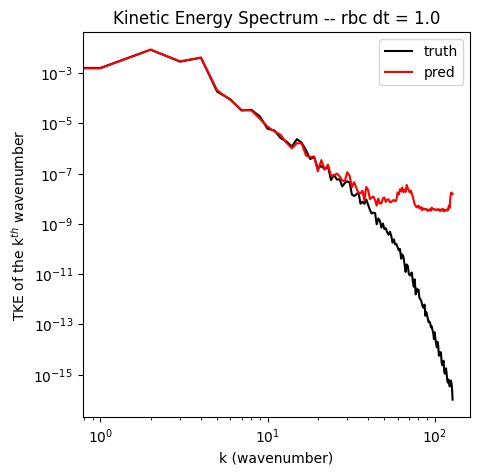

In [11]:
model_dic = "results/PASR_MLP_small_data_rbc_small_crop_size_256_ode_step_8_ode_method_Euler_task_dt_4_num_snapshots_20_upscale_factor_4_timescale_factor_5_loss_type_L1_lamb_0.3_lr_0.0003_gamma_0.95_normalizaiton_Falsetensor([[736]]).pt"
lr_input,hr_target,lr_input_tensor,hr_target_tensor = get_test_data("rbc",timescale_factor = 5,num_snapshot = 20,in_channel=3,upscale_factor=4)
pred = get_prediction(model_dic,lr_input_tensor,hr_target_tensor,scale_factor=4,in_channels=3,task_dt=4,n_snapshot=20,ode_step=8)
u_truth = hr_target[:,:,1].transpose(0,1,2,3).reshape(-1,pred.shape[-2],pred.shape[-1])
v_truth = hr_target[:,:,2].transpose(0,1,2,3).reshape(-1,pred.shape[-2],pred.shape[-1])
u_pred = pred[:,:,1].transpose(0,1,2,3).reshape(-1,pred.shape[-2],pred.shape[-1])
v_pred = pred[:,:,2].transpose(0,1,2,3).reshape(-1,pred.shape[-2],pred.shape[-1])
plot_energy_specturm(u_truth,v_truth,u_pred,v_pred,"rbc")

Text(0, 0.5, 'time')

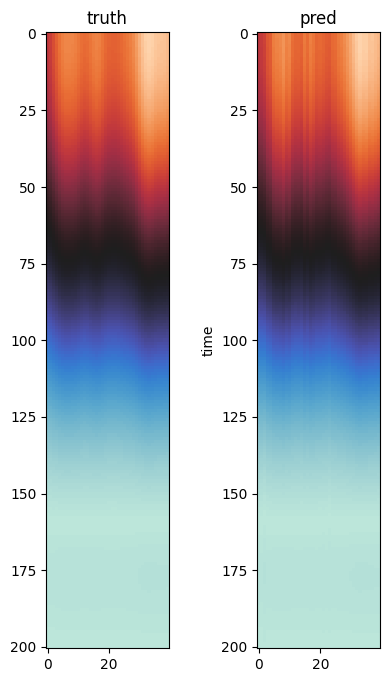

In [12]:
import torchaudio
fig,ax = plt.subplots(1,2,figsize=(5,8))
energy_truth = 0.5*(u_truth**2 + v_truth**2) # (t,h,w)
E_t = energy_truth.reshape(energy_truth.shape[0],-1)
E_t = E_t.mean(axis=1)

spectrogram = torchaudio.transforms.Spectrogram(win_length=5, hop_length=10, power=1).cuda()
wfs = torch.Tensor(E_t.T)
wfs = wfs.cuda().float()
wfs = spectrogram(wfs)
ax[0].imshow(wfs.cpu().numpy(),cmap=CMAP,vmin =0)
ax[0].set_title("truth")

energy_pred = 0.5*(u_pred**2 + v_pred**2) # (t,h,w)
E_t = energy_pred.reshape(energy_pred.shape[0],-1)
E_t = E_t.mean(axis=1)
spectrogram = torchaudio.transforms.Spectrogram(win_length=5, hop_length=10, power=1).cuda()
wfs = torch.Tensor(E_t.T)
wfs = wfs.cuda().float()
wfs = spectrogram(wfs)
ax[1].imshow(wfs.cpu().numpy(),cmap=CMAP,vmin =0)
ax[1].set_title("pred")
ax[1].set_ylabel("time")

[[100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175 180 185
  190 195 200]
 [200 205 210 215 220 225 230 235 240 245 250 255 260 265 270 275 280 285
  290 295 300]
 [300 305 310 315 320 325 330 335 340 345 350 355 360 365 370 375 380 385
  390 395 400]]
(19, 21, 3, 128, 128)
shape of data =  (399, 2, 128, 128)
Reading files...localtime Tue Sep  5 03:18:26 2023 - END

Computing spectrum...  Tue Sep  5 03:18:26 2023
N = 128
M = 128
amplsU.shape = (128, 128)
box sidex     = 128
box sidey     = 128
sphere radius = 92
centerbox     = 64
centerboy     = 64
{'Real Kmax': 65, 'Spherical Kmax': 92, 'KE of the mean velocity discrete': 7.415755375195268e-18, 'KE of the mean velocity sphere': 1.2764626407590617e-16, 'Mean KE discrete': 0.15647736191749573, 'Mean KE sphere': 0.15647737180258603}
Computing spectrum...  Tue Sep  5 03:18:26 2023 - END 

shape of data =  (399, 2, 128, 128)
Reading files...localtime Tue Sep  5 03:18:26 2023 - END

Computing spectrum...  Tue Sep  5 03:18:26

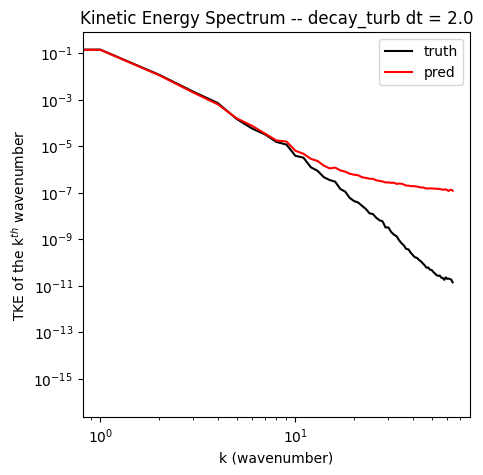

In [13]:
import h5py


model_dic = "results/PASR_MLP_small_data_Decay_turb_small_crop_size_256_ode_step_8_ode_method_Euler_task_dt_4_num_snapshots_20_upscale_factor_4_timescale_factor_5_loss_type_L1_lamb_1.0_lr_0.0002_gamma_0.95_normalizaiton_Falsetensor([[1286]]).pt"
lr_input,hr_target,lr_input_tensor,hr_target_tensor = get_test_data("decay_turb",timescale_factor = 5,num_snapshot = 20,in_channel=3,upscale_factor=4)
pred = get_prediction(model_dic,lr_input_tensor,hr_target_tensor,scale_factor=4,in_channels=3,task_dt=4,n_snapshot=20,ode_step=8)
u_truth = hr_target[:,:,1].transpose(0,1,2,3).reshape(-1,pred.shape[-2],pred.shape[-1])
v_truth = hr_target[:,:,2].transpose(0,1,2,3).reshape(-1,pred.shape[-2],pred.shape[-1])
u_pred = pred[:,:,1].transpose(0,1,2,3).reshape(-1,pred.shape[-2],pred.shape[-1])
v_pred = pred[:,:,2].transpose(0,1,2,3).reshape(-1,pred.shape[-2],pred.shape[-1])

plot_energy_specturm(u_truth,v_truth,u_pred,v_pred,'decay_turb')


[[100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175 180 185
  190 195 200]
 [200 205 210 215 220 225 230 235 240 245 250 255 260 265 270 275 280 285
  290 295 300]
 [300 305 310 315 320 325 330 335 340 345 350 355 360 365 370 375 380 385
  390 395 400]]
(10, 21, 2, 128, 128)
shape of data =  (210, 2, 128, 128)
Reading files...localtime Tue Sep  5 03:18:28 2023 - END

Computing spectrum...  Tue Sep  5 03:18:28 2023
N = 128
M = 128
amplsU.shape = (128, 128)
box sidex     = 128
box sidey     = 128
sphere radius = 92
centerbox     = 64
centerboy     = 64
{'Real Kmax': 65, 'Spherical Kmax': 92, 'KE of the mean velocity discrete': 0.6020148078034917, 'KE of the mean velocity sphere': 0.6020148078034917, 'Mean KE discrete': 0.6101932442803584, 'Mean KE sphere': 0.6101932442803675}
Computing spectrum...  Tue Sep  5 03:18:28 2023 - END 

shape of data =  (210, 2, 128, 128)
Reading files...localtime Tue Sep  5 03:18:28 2023 - END

Computing spectrum...  Tue Sep  5 03:18:28 2023
N =

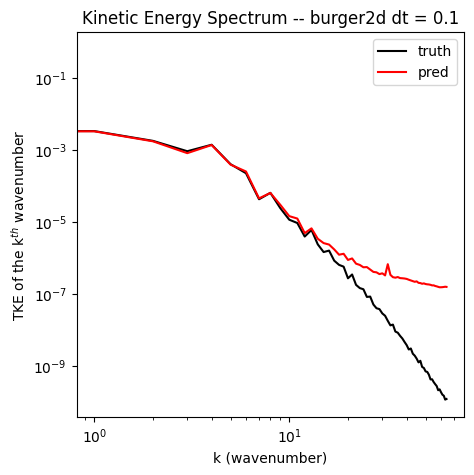

In [14]:
import h5py


model_dic = "results/PASR_MLP_small_data_Burger2D_small_crop_size_256_ode_step_8_ode_method_Euler_task_dt_4_num_snapshots_20_upscale_factor_4_timescale_factor_5_loss_type_L1_lamb_0.3_lr_0.0005_gamma_0.95_normalizaiton_Falsetensor([[3624]]).pt"
lr_input,hr_target,lr_input_tensor,hr_target_tensor = get_test_data("burger2d",timescale_factor = 5,num_snapshot = 20,in_channel=2,upscale_factor=4)
pred = get_prediction(model_dic,lr_input_tensor,hr_target_tensor,scale_factor=4,in_channels=2,task_dt=4,n_snapshot=20,ode_step=8)
u_truth = hr_target[:,:,0].transpose(0,1,2,3).reshape(-1,pred.shape[-2],pred.shape[-1])
v_truth = hr_target[:,:,1].transpose(0,1,2,3).reshape(-1,pred.shape[-2],pred.shape[-1])
u_pred = pred[:,:,0].transpose(0,1,2,3).reshape(-1,pred.shape[-2],pred.shape[-1])
v_pred = pred[:,:,1].transpose(0,1,2,3).reshape(-1,pred.shape[-2],pred.shape[-1])

plot_energy_specturm(u_truth[:],v_truth[:],u_pred[:],v_pred[:],'burger2d')


# Vorticity Correlation

[[100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175 180 185
  190 195 200]
 [200 205 210 215 220 225 230 235 240 245 250 255 260 265 270 275 280 285
  290 295 300]
 [300 305 310 315 320 325 330 335 340 345 350 355 360 365 370 375 380 385
  390 395 400]]
(19, 21, 3, 256, 64)


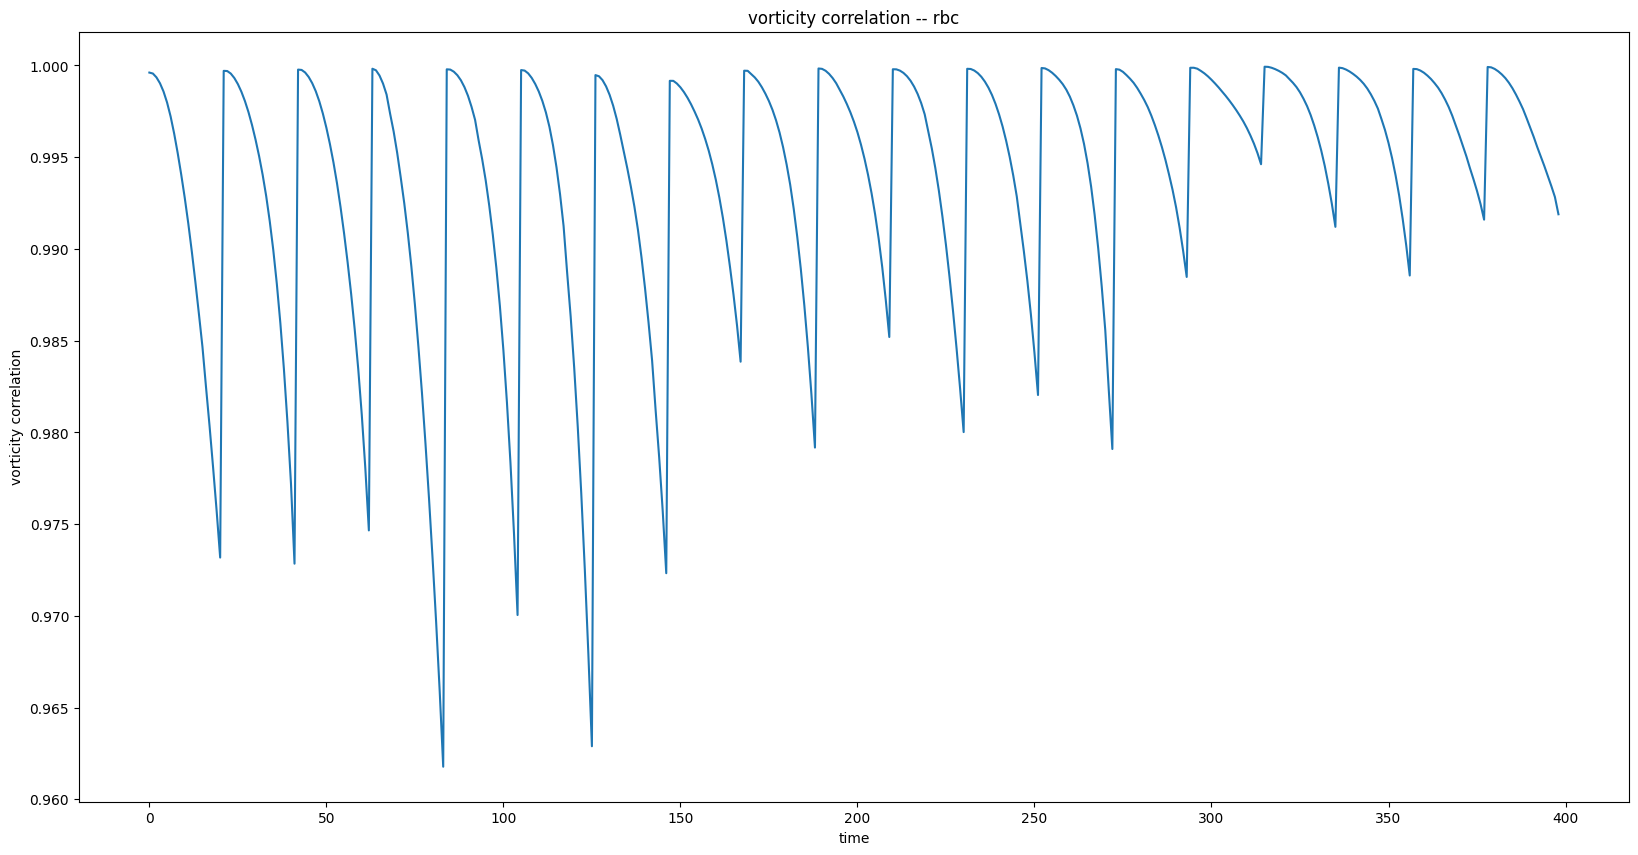

In [21]:
import numpy as np
from scipy.stats import pearsonr
from scipy.ndimage import zoom

def plot_vorticity_correlation(data_name,pred,reference_data):
    
    correlations = np.zeros(pred.shape[0])
    for t in range(pred.shape[0]):
        ref_flat = reference_data[t].flatten()
        gen_flat = pred[t].flatten()
        corr, _ = pearsonr(ref_flat, gen_flat)
        correlations[t] = corr
    fig,axs = plt.subplots(1,1,figsize=(20,10))
    axs.plot(np.arange(0,w_truth.shape[0]),correlations)
    axs.set_ylabel("vorticity correlation")
    axs.set_xlabel("time")
    axs.set_title(f"vorticity correlation -- {data_name}")
    return None

lr_input,hr_target,lr_input_tensor,hr_target_tensor = get_test_data('rbc',timescale_factor = 5,num_snapshot = 20,in_channel=3,upscale_factor=4)
model_dic = "results/PASR_MLP_small_data_rbc_small_crop_size_256_ode_step_8_ode_method_Euler_task_dt_4_num_snapshots_20_upscale_factor_4_timescale_factor_5_loss_type_L1_lamb_0.3_lr_0.0003_gamma_0.95_normalizaiton_Falsetensor([[736]]).pt"
pred = get_prediction(model_dic,lr_input_tensor,hr_target_tensor,scale_factor=4,in_channels=3,task_dt=4,n_snapshot=20,ode_step=8)
w_truth = hr_target[:,:,0].transpose(0,1,2,3).reshape(-1,pred.shape[-2],pred.shape[-1])
w_pred = pred[:,:,0].transpose(0,1,2,3).reshape(-1,pred.shape[-2],pred.shape[-1])

plot_vorticity_correlation("rbc",w_pred,w_truth)

[[100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175 180 185
  190 195 200]
 [200 205 210 215 220 225 230 235 240 245 250 255 260 265 270 275 280 285
  290 295 300]
 [300 305 310 315 320 325 330 335 340 345 350 355 360 365 370 375 380 385
  390 395 400]]
(19, 21, 3, 128, 128)


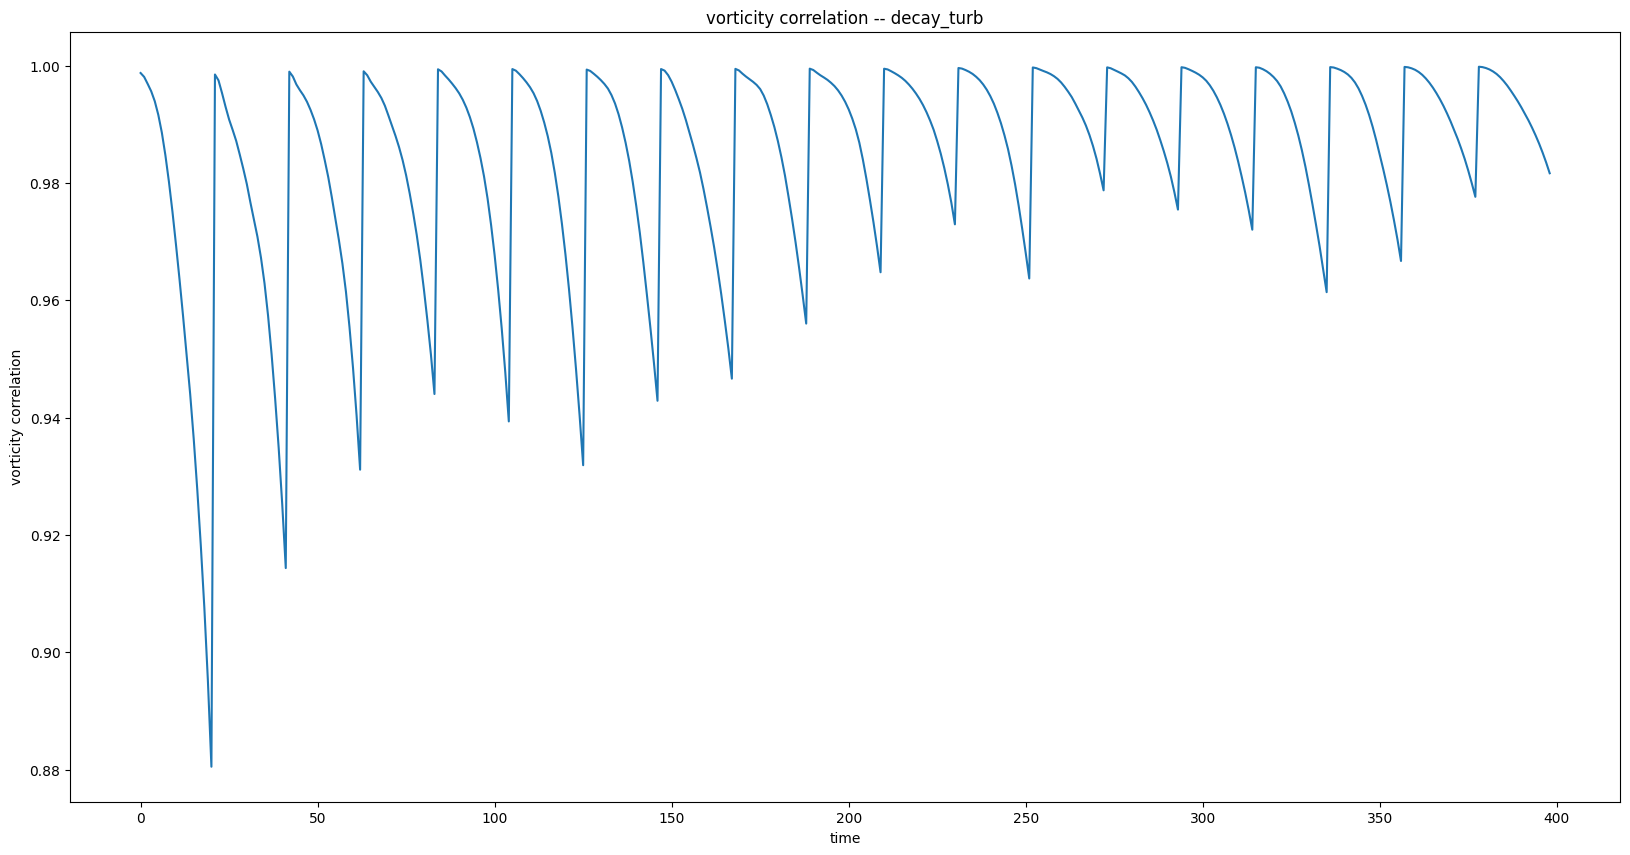

In [20]:
import numpy as np
from scipy.stats import pearsonr
from scipy.ndimage import zoom

lr_input,hr_target,lr_input_tensor,hr_target_tensor = get_test_data('decay_turb',timescale_factor = 5,num_snapshot = 20,in_channel=3,upscale_factor=4)
model_dic = "results/PASR_MLP_small_data_Decay_turb_small_crop_size_256_ode_step_8_ode_method_Euler_task_dt_4_num_snapshots_20_upscale_factor_4_timescale_factor_5_loss_type_L1_lamb_1.0_lr_0.0002_gamma_0.95_normalizaiton_Falsetensor([[1286]]).pt"
pred = get_prediction(model_dic,lr_input_tensor,hr_target_tensor,scale_factor=4,in_channels=3,task_dt=4,n_snapshot=20,ode_step=8)
w_truth = hr_target[:,:,0].transpose(0,1,2,3).reshape(-1,pred.shape[-2],pred.shape[-1])
w_pred = pred[:,:,0].transpose(0,1,2,3).reshape(-1,pred.shape[-2],pred.shape[-1])

plot_vorticity_correlation("decay_turb",w_pred,w_truth)



In [37]:
def plot_PDF(data_name,pred,truth,lr_input):
    import numpy as np
    from scipy.interpolate import UnivariateSpline
    from matplotlib import pyplot as plt
    s_pred3 = lr_input[:,:,0].flatten()
    n3 = s_pred3.shape[0]
    s_pred = pred.flatten()
    n = n3
    p, x = np.histogram(s_pred, bins=n) # bin it into n = N//10 bins
    p2,x2 = np.histogram(truth.flatten(), bins=n)
    p3,x3 = np.histogram(s_pred3, bins=n)
    x3 = x3[:-1] + (x3[1] - x3[0])/2   # convert bin edges to centers
    x2 = x2[:-1] + (x2[1] - x2[0])/2   # convert bin edges to centers
    x = x[:-1] + (x[1] - x[0])/2   # convert bin edges to centers

    f = UnivariateSpline(x, p, s=n)
    f2 = UnivariateSpline(x2, p2, s=n)
    f3 = UnivariateSpline(x3, p3, s=n)
    plt.figure()
    plt.plot(x,f(x))
    plt.plot(x2,f2(x2))
    plt.plot(x3,f3(x3))
    plt.yscale('log')
    return print("PDF plot done")

In [38]:
plot_PDF("decay_turb",w_pred,w_truth,lr_input[0])

ValueError: x and y should have a same length

In [17]:
import numpy as np

# Create some example data with shape [10, 29, 64, 64]
A = np.random.rand(10, 29, 64, 64)

# Reshape and rearrange the data
B = A.transpose(0, 1, 2, 3).reshape(-1, 64, 64)

# Check the shape of the new array
print("Shape of B:", B.shape)  # Should print (290, 64, 64)

# Validate that B[0] == A[0, 0], B[1] == A[0, 1], B[2] == A[0, 2], etc.
for i in range(10):
    for j in range(29):
        if not np.all(B[i * 29 + j] == A[i, j]):
            print(f"B[{i * 29 + j}] is not equal to A[{i}, {j}]")
            break
    else:
        continue
    break
else:
    print("All elements match!")


Shape of B: (290, 64, 64)
All elements match!


# Evaluation 

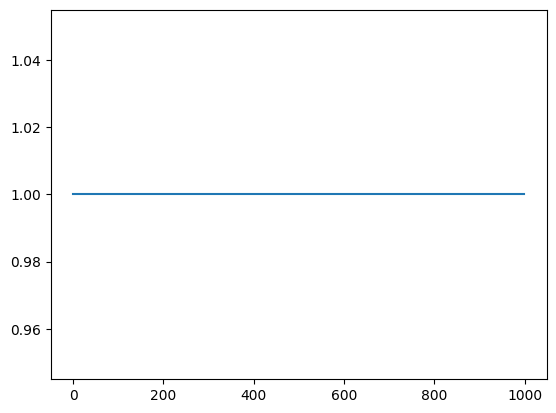

In [18]:
import numpy as np
from scipy.stats import pearsonr
from scipy.ndimage import zoom

# Simulate your reference and generative data
reference_data = np.random.rand(1000, 256, 256)
generative_data = np.random.rand(1000, 256, 256)
generative_data = reference_data
# Rescale generative_data to match the shape of reference_data
# You can also downsample reference_data to match the shape of generative_data


# Initialize an array to store correlation values
correlations = np.zeros(1000)

# Loop through each time-step to calculate correlation
for t in range(1000):
    ref_flat = reference_data[t].flatten()
    gen_flat = generative_data[t].flatten()
    corr, _ = pearsonr(ref_flat, gen_flat)
    correlations[t] = corr

# Now, `correlations` contains the Pearson correlation coefficients for each time-step
plt.plot(correlations)